## Pre-procesamiento

### 1. Imports y constantes

In [1]:
import os
import sys
import shutil
import typing
import glob

import pandas as pd
import numpy as np

from math import floor
from xml.etree import ElementTree
import collections
import seaborn as sns


In [3]:

RUTA_RDD = "."
CARPETAS_INTERES = ["/China_Drone", "/China_MotorBike", "/Czech", "/India", "/Japan", "/Norway", "/United_States"]
CARPETAS_INTERES = ["/DATA_borrar"]
CARPETA_SALIDA = []
RUTA_IMAGENES = "/train/images"
RUTA_ANOTACIONES_ORIGINALES = "/train/annotations/xmls"
# RUTA_ANOTACIONES_SALIDA = f'{RUTA_RDD}/labels_salida'
RUTA_ANOTACIONES_SALIDA = f'{RUTA_RDD}/DATA_borrar/labels_salida'
ETIQUETAS_ENTRADA = ["D00","D01","D10","D11","D20","D40","D43","D44", "D50", "Repair"]

### 2. Cantidad de imagenes, chequeo de anotaciones y distribución de etiquetas

Cantidad de imagenes: 5010
Todas las imagenes tienen anotaciones
Background images (cantidad de archivos xml sin etiquetas): 393 (12.75%)
Etiqueta adicional encontrada pero no declarada: BG


c:\Users\enime\miniconda3\envs\object_detection\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

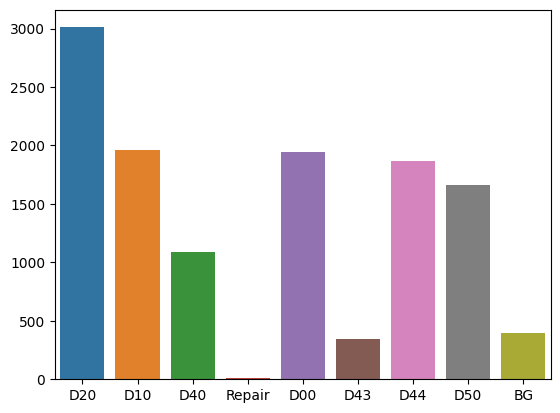

In [9]:
# Mostrar cantidad de imagenes
imagenes_por_pais = {}
rutas_imagenes = []
for pais in CARPETAS_INTERES:
    rutas_imagenes.extend(os.listdir(f'{RUTA_RDD}/{pais}/{RUTA_IMAGENES}'))    
    imagenes_por_pais[pais] = rutas_imagenes

print(f'Cantidad de imagenes: {len(rutas_imagenes)}')

# Chequear existencia de todas las anotaciones
anotaciones = []
ruta_anotacion = ''
for pais in imagenes_por_pais:
    for ruta in imagenes_por_pais[pais]:
        # Chequear que exista la anotacion correspondiente
        archivo_anotacion = '/' + os.path.splitext(ruta)[-2] + ".xml"
        ruta_anotacion = RUTA_RDD + pais + RUTA_ANOTACIONES_ORIGINALES + archivo_anotacion
        if os.path.isfile(ruta_anotacion):
            anotaciones.append(ruta_anotacion)
            
anotaciones_faltantes = len(rutas_imagenes) - len(anotaciones)
if anotaciones_faltantes == 0:
    print("Todas las imagenes tienen anotaciones")
else:
    print(f'Faltan {anotaciones_faltantes} anotaciones')

# Chequear etiquetas declaradas (ETIQUETAS_ENTRADA)
cls_names = []
anotaciones_sin_etiquetas = []
for ruta_anotacion in anotaciones:
    infile_xml = open(ruta_anotacion)
    tree = ElementTree.parse(infile_xml)
    root = tree.getroot()
    
    if root.find('object') is None: 
        anotaciones_sin_etiquetas.append(ruta_anotacion)
        cls_names.append('BG')
        continue
    
    for obj in root.iter('object'):
        cls_name = obj.find('name').text
        cls_names.append(cls_name)
        
    if cls_name == 'D0w0': print(f'revisar ruta {ruta_anotacion}')

porcentaje:float = len(anotaciones) / len(anotaciones_sin_etiquetas)
print(f'Background images (cantidad de archivos xml sin etiquetas): ' + \
    f'{len(anotaciones_sin_etiquetas)} ' + \
    f'({porcentaje:.2f}%)')


count_dict = collections.Counter(cls_names)

for clave in count_dict.keys():
    if clave not in ETIQUETAS_ENTRADA: 
        print(f'Etiqueta adicional encontrada pero no declarada: {clave}')

# Mostrar cantidad de ejemplos de cada etiqueta
cls_dict = {}
for damageType in cls_names:
    cls_dict[damageType] = [count_dict[damageType]]
df = pd.DataFrame.from_dict(cls_dict)

# sns.set_palette("winter", 8)
sns.barplot(df)


### 3. Limpieza

In [10]:
def copiar_xmls(anotaciones):
    # Esta funcion copia los xmls validos
    
    lista = os.listdir(RUTA_ANOTACIONES_SALIDA)
    for elemento in lista:
        if not os.path.isdir(f'{RUTA_ANOTACIONES_SALIDA}/{elemento}'):
            print(f'El directorio de salida no debe contener archivos. Ruta: {RUTA_ANOTACIONES_SALIDA}')
            return
    
    for ruta_anotacion in anotaciones:        
        nombre_archivo = os.path.split(ruta_anotacion)[1]
        ruta_anotacion_destino = f'{RUTA_ANOTACIONES_SALIDA}/{nombre_archivo}'
        shutil.copy(ruta_anotacion, ruta_anotacion_destino)

def generar_txts(anotaciones_sin_etiquetas):
    # Por un lado, se procesan las anotaciones vacias
    for anotacion_vacia in anotaciones_sin_etiquetas:
        nombre_archivo = os.path.split(anotacion_vacia)[1].split(".")[0]
        # Genero txt vacio
        with open(f'{RUTA_ANOTACIONES_SALIDA}/txts/{nombre_archivo}.txt', 'w'): pass
        
    # Por otro, se procesan las anotaciones validas
    ruta_archivo_clases = './classes.txt'
    with open(ruta_archivo_clases, 'w') as file:
        [file.write(f'{clase}\n') for clase in ETIQUETAS_ENTRADA]
    
    print('Ejecutar la siguiente linea en la consola del ambiente:')
    print(f"python XmlToTxt/xmltotxt.py -xml {RUTA_ANOTACIONES_SALIDA} -out {RUTA_ANOTACIONES_SALIDA}/txts -c {ruta_archivo_clases}")
    


In [12]:
anotaciones_validas:list = anotaciones.copy()
[anotaciones_validas.remove(anotacion_invalida) for anotacion_invalida in anotaciones_sin_etiquetas]

copiar_xmls(anotaciones_validas)
generar_txts(anotaciones_sin_etiquetas)

Ejecutar la siguiente linea en la consola del ambiente:
python XmlToTxt/xmltotxt.py -xml ./DATA/labels_salida -out ./DATA/labels_salida/txts -c classes.txt


Hasta acá tenemos los txt como los necesita yolo. Las aumentaciones se pueden hacer desde roboflow

#### 3.1 Separacion del dataset

In [ ]:
RUTA_IMAGENES_TEST = "/test/images"
RUTA_ANOTACIONES_SALIDA_TEST = "/test/labels"
RUTA_ANOTACIONES_SALIDA_TRAIN = "/train/labels"

def separar_dataset(porcentaje_testing = 0.2):
    lista_imagenes = os.listdir(f'{RUTA_ANOTACIONES_SALIDA}/txts')
    cant_imagenes_testing = floor(porcentaje_testing * len(lista_imagenes))
    np.random.shuffle(lista_imagenes)
    lista_testing = lista_imagenes[0:cant_imagenes_testing]
    lista_training = lista_imagenes[cant_imagenes_testing:]
    
    for archivo_anotacion in lista_testing:
        # Mover imagen
        imagen = archivo_anotacion.split(".")[0] + '.jpg'
        ruta_origen = f'{RUTA_RDD}/{CARPETAS_INTERES[0]}/{RUTA_IMAGENES}/{imagen}'
        ruta_destino = f'{RUTA_RDD}/{CARPETAS_INTERES[0]}/{RUTA_IMAGENES_TEST}/{imagen}'
        shutil.move(ruta_origen, ruta_destino)
        
        # Mover anotacion
        ruta_origen = f'{RUTA_ANOTACIONES_SALIDA}/txts/{archivo_anotacion}'
        ruta_destino = f'{RUTA_RDD}/{CARPETAS_INTERES[0]}/{RUTA_ANOTACIONES_SALIDA_TEST}/{archivo_anotacion}'
        shutil.move(ruta_origen, ruta_destino)
        
    for archivo_anotacion in lista_training:
        # Mover anotacion
        ruta_origen = f'{RUTA_ANOTACIONES_SALIDA}/txts/{archivo_anotacion}'
        ruta_destino = f'{RUTA_RDD}/{CARPETAS_INTERES[0]}/{RUTA_ANOTACIONES_SALIDA_TRAIN}/{archivo_anotacion}'
        shutil.move(ruta_origen, ruta_destino)

separar_dataset(0.1)

Listo para pasar a entrenamiento (etapa2) y/o subir a roboflow

## Apéndice

#### 3.2 Funcion para unir clases

#### 3.3 Funcion para quitar clases

#### 3.4 Armo un dataset reducido

In [ ]:
def ruta_imagen_desde_ruta_anotacion(ruta_anotacion:str) -> str:
    RUTA_DATASET_REDUCIDO = 'Japan_reduced'
    _, nombre_archivo = os.path.split(ruta_anotacion)
    nombre_archivo = os.path.splitext(nombre_archivo)[0] + '.jpg'
    ruta_base_destino = os.path.join(RUTA_RDD, RUTA_DATASET_REDUCIDO, RUTA_IMAGENES)
    ruta_imagen_destino = os.path.join(ruta_base_destino, nombre_archivo)
    ruta_base_original = os.path.join(RUTA_RDD, 'Japan', RUTA_IMAGENES)
    ruta_imagen_original = os.path.join(ruta_base_original, nombre_archivo)

    return ruta_imagen_original, ruta_imagen_destino

def muestrear_dataset_desde_etiquetas(factor_escala:float, lista_anotaciones: typing.List[str]):    
    anotaciones_mezcladas = lista_anotaciones.copy()
    np.random.shuffle(anotaciones_mezcladas)
    print(anotaciones_mezcladas[0])
    anotaciones_reducidas = anotaciones_mezcladas[:floor(len(lista_anotaciones)*factor_escala)]
    print(f'Cantidad imagenes en dataset reducido: {len(anotaciones_reducidas)}')
    
    for ruta_anotacion in anotaciones_reducidas:
        ruta_anotacion:str
        ruta_base_anotacion_destino, nombre_archivo = os.path.split(ruta_anotacion)
        ruta_base_anotacion_destino = ruta_base_anotacion_destino.replace('Japan', 'Japan_reduced')
        ruta_anotacion_destino = os.path.join(ruta_base_anotacion_destino, nombre_archivo)
        shutil.copy(ruta_anotacion, ruta_anotacion_destino)
    
        ruta_img_original, ruta_img_destino = ruta_imagen_desde_ruta_anotacion(ruta_anotacion)    
        shutil.copy(ruta_img_original, ruta_img_destino)

In [ ]:

# anotaciones_con_etiquetas = anotaciones.copy()
# [anotaciones_con_etiquetas.remove(anotacion_sin_etiquetas) for anotacion_sin_etiquetas in anotaciones_sin_etiquetas]
# muestrear_dataset_desde_etiquetas(factor_escala=0.15, lista_anotaciones=anotaciones_con_etiquetas)
    